In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
import FinancialMachineLearning as fml

### Chapter 14. Backtest Statistics

#### Exercise 1
특정 전략이 높은 매매 회전율, 높은 레버리지, 높은 베팅 개수, 짧은 보유 기간, 낮은 실행 비용 대비 수익률, 높은 Sharpe Ratio를 가진다고 하자. Capacity가 클 것으로 생각되는가? 이것은 어떤 종류의 전략으로 보이는가?

선물과 같은 소수의 상품에 대한 차익거래 전략과 유사한 것으로 보인다. 보유 기간이 짧고 높은 전략은 일반적으로 Capacity가 낮은 경향이 있다

#### Exercise 2
E-mini S&P 500 선물의 달러 바 데이터셋에 대해 다음을 계산하라.

In [2]:
df = pd.read_parquet('./Data/IVE_tickbidask.parq')
mad = fml.madOutlier(df.price.values.reshape(-1, 1))
df = df.loc[~mad]
dollar_M = 1000000
dollar_df = fml.BarSampling(df, 'dv', dollar_M)

86.96
[36.17 36.25 36.21 ... 29.26 29.26 29.26]
[1.41225268 1.41537627 1.41381447 ... 1.14245268 1.14245268 1.14245268]


In [3]:
dollar_df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:46:35,51.07,51.05,51.07,900,900,45963.00
2009-09-28 09:53:49,51.14,51.13,51.14,2000,2000,102280.00
2009-09-28 09:55:26,51.14,51.11,51.14,100,100,5114.00
2009-09-28 10:02:52,51.25,51.24,51.26,4300,4300,220375.00
2009-09-28 10:10:21,51.29,51.28,51.29,4500,4500,230805.00
...,...,...,...,...,...,...
2018-10-05 15:58:23,116.19,116.19,116.20,1354,1354,157321.26
2018-10-05 15:59:20,116.18,116.17,116.19,300,300,34854.00
2018-10-05 15:59:55,116.19,116.18,116.20,800,800,92952.00


**(a)** 양의 수익률에 대한 HHI index

In [4]:
ret = (dollar_df['price'] - dollar_df['price'].shift(1)) / dollar_df['price'].shift(1)
ret

dates
2009-09-28 09:46:35         NaN
2009-09-28 09:53:49    0.001371
2009-09-28 09:55:26    0.000000
2009-09-28 10:02:52    0.002151
2009-09-28 10:10:21    0.000780
                         ...   
2018-10-05 15:58:23   -0.000430
2018-10-05 15:59:20   -0.000086
2018-10-05 15:59:55    0.000086
2018-10-05 15:59:59    0.000086
2018-10-05 16:00:00    0.000172
Name: price, Length: 50766, dtype: float64

In [5]:
fml.getHHI(ret[ret >= 0])

0.00021670938102371894

**(b)** 음의 수익률에 대한 HHI index

In [6]:
fml.getHHI(ret[ret < 0])

0.0001938681018384944

**(c)** bar 사이 시간의 HHI index

In [7]:
fml.getHHI(ret.groupby(pd.Grouper(freq = 'M')).count())

0.0022141701516628113

**(d)** 95백분위의 Draw Down

In [8]:
DD, tuW = fml.computeDD_TuW(ret.dropna())

In [9]:
np.quantile(DD, 0.95)

15.633492384764438

**(e)** 95백분위의 TuW

In [10]:
np.quantile(tuW, 0.95)

0.4542787845923775

**(f)** 연환산 평균 수익률

In [11]:
(ret + 1).prod() ** 0.1 - 1

0.08570415861143288

**(g)** 히트로부터의 평균 수익률

In [12]:
ret[ret >= 0].mean()

0.001082506359850725

**(h)** 미스로부터의 평균 수익률

In [13]:
ret[ret < 0].mean()

-0.0011569874483164516

**(i)** 연환산 Sharpe Ratio

In [14]:
ret.mean() / ret.std() * ret.groupby(pd.Grouper(freq = 'Y')).count().mean() ** 0.5

0.5132088565117002

**(j)** 정보 비율, 여기서 벤치마크는 무위험 이자율

In [15]:
ret.std()

0.0027886796448252918

In [16]:
avg_ret = (ret + 1).prod() ** 0.1 - 1
risk_free = 0.025
info_ratio = (avg_ret - risk_free) / ret.std()

In [17]:
info_ratio

21.768064583566012

**(k)** Probabilistic Sharpe Ratio

In [18]:
from scipy.stats import norm, skew, kurtosis
sr = ret.mean() / ret.std()
val = sr * np.sqrt(len(ret) - 1) / np.sqrt(1 - skew(ret.dropna()) * sr + (kurtosis(ret.dropna()) - 1) / 4 * sr ** 2)
norm.cdf(val)

0.9484023982155377

**(l)** Deflated Sharpe Ratio, 여기서 100개의 시행이 수행되고, 이들 시행의 Sharpe Ratio 분산은 0.5로 가정한다

In [19]:
var = 0.5
N = 100
gamma = 0.5772 # Euler-Mascheroni

dsr = np.sqrt(var) * ((1 - gamma) * norm.cdf(1 - 1 / N) ** (-1) + gamma * norm.cdf(1 - 1 / N * np.exp(1) ** (-1)) ** (-1))

In [20]:
dsr

0.8419931154169011

#### Exercise 3
짝수 해에는 선물을 매수하고, 홀수 해에는 선물 계약을 매도하는 전략을 고려해 보자

In [21]:
returns_custom = ret.copy(deep=True)
for ind in returns_custom.index:
    if ind.year % 2 == 1:
        returns_custom[ind] *= -1
returns_custom

dates
2009-09-28 09:46:35         NaN
2009-09-28 09:53:49   -0.001371
2009-09-28 09:55:26   -0.000000
2009-09-28 10:02:52   -0.002151
2009-09-28 10:10:21   -0.000780
                         ...   
2018-10-05 15:58:23   -0.000430
2018-10-05 15:59:20   -0.000086
2018-10-05 15:59:55    0.000086
2018-10-05 15:59:59    0.000086
2018-10-05 16:00:00    0.000172
Name: price, Length: 50766, dtype: float64

**(a)** Exercise 2의 계산을 반복하라

In [22]:
fml.getHHI(returns_custom[returns_custom >= 0]) # long position HHI index

0.00022310515075823662

In [23]:
fml.getHHI(returns_custom[returns_custom < 0]) # Short position HHI index

0.00018815985622109104

In [24]:
fml.getHHI(returns_custom.groupby(pd.Grouper(freq = 'M')).count()) # HHI index btw bar time

0.0022141701516628113

In [25]:
DD, tuW = fml.computeDD_TuW(returns_custom.dropna())

In [26]:
np.quantile(DD, 0.95)

10.172838663013485

In [27]:
np.quantile(tuW, 0.95)

0.3387963102393411

In [28]:
(returns_custom + 1).prod() ** 0.1 - 1

0.0025837778666149003

In [29]:
returns_custom[returns_custom >= 0].mean()

0.0010852343099613457

In [30]:
returns_custom[returns_custom < 0].mean()

-0.0011527484293949806

In [31]:
returns_custom.mean() / returns_custom.std() * returns_custom.groupby(pd.Grouper(freq = 'Y')).count().mean() ** 0.5

0.1123805604025786

In [32]:
returns_custom.std()

0.0027887485186368233

In [33]:
avg_ret = (returns_custom + 1).prod() ** 0.1 - 1
risk_free = 0.025
info_ratio = (avg_ret - risk_free) / returns_custom.std()

In [34]:
info_ratio

-8.03809378421201

In [35]:
from scipy.stats import norm, skew, kurtosis
sr = returns_custom.mean() / returns_custom.std()
val = sr * np.sqrt(len(returns_custom) - 1) / np.sqrt(1 - skew(returns_custom.dropna()) * sr + (kurtosis(returns_custom.dropna()) - 1) / 4 * sr ** 2)
norm.cdf(val)

0.6396801182694368

In [36]:
var = 0.5
N = 100
gamma = 0.5772 # Euler-Mascheroni

dsr = np.sqrt(var) * ((1 - gamma) * norm.cdf(1 - 1 / N) ** (-1) + gamma * norm.cdf(1 - 1 / N * np.exp(1) ** (-1)) ** (-1))
dsr

0.8419931154169011

**(b)** 기초 자산과의 상관관계는 무엇인가?

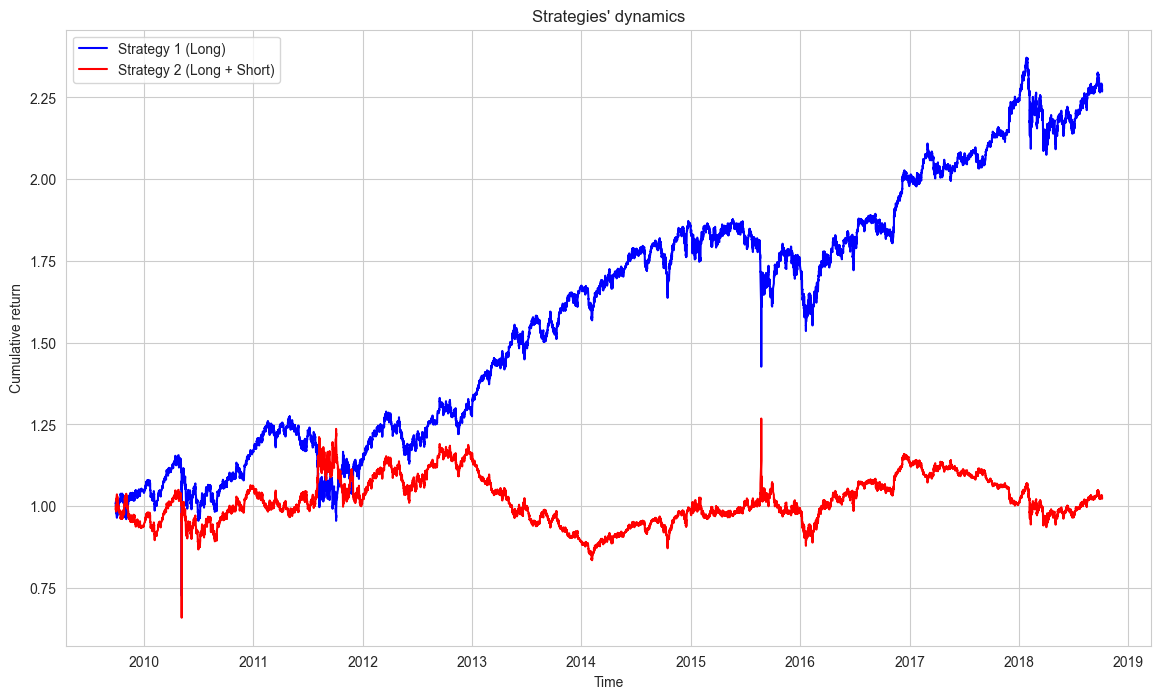

In [37]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot((1 + ret).cumprod(), color='blue', label='Strategy 1 (Long)')
ax.plot((1 + returns_custom).cumprod(), color='red', label='Strategy 2 (Long + Short)')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative return')
ax.set_title('Strategies\' dynamics')
ax.legend(loc='best')
plt.show()

In [38]:
np.corrcoef(ret.dropna(), returns_custom.dropna())

array([[1.        , 0.43059055],
       [0.43059055, 1.        ]])

#### Exercise 4
2년 백테스트 결과, 월별 수익률 평균을 3.6%, 표준 편차는 0.079%다

**(a)** Sharpe Ratio는 얼마인가?

In [39]:
avg_month_ret = 0.036
avg_std = 0.079

sharpe_ratio = avg_month_ret / avg_std
sharpe_ratio

0.45569620253164556

**(b)** 연환산 Sharpe Ratio는 얼마인가?

In [40]:
year_sharpe_ratio = avg_month_ret / avg_std * np.sqrt(12)
year_sharpe_ratio

1.5785779512020146

#### Exercise 5

이전 연습 문제에 이어 다음을 구하라

**(a)** 수익률은 왜도 0과 첨도 3을 가진다. Probabilistic Sharpe Ratio를 구하라

In [41]:
import scipy.stats as ss

def PSR(sharpe, T, skew, kurtosis, target_sharpe = 0):
    value = (
        (sharpe - target_sharpe)
        * np.sqrt(T - 1)
        / np.sqrt(1.0 - skew * sharpe + sharpe ** 2 * (kurtosis - 1) / 4.0)
    )
    psr = ss.norm.cdf(value, 0, 1)
    return psr

ske = 0
kur = 3

In [42]:
PSR(sharpe_ratio, 12, ske, kur)

0.9248589923050501

**(b)** 수익률은 왜도 -2.448과 첨도 0.164를 가진다. Probabilistic Charpe Ratio를 구하라

In [43]:
PSR(sharpe_ratio, 12, -2.448, 0.164)

0.8531256771878033

#### Exercise 6
Back Test가 3년 기간으로 시행되었다면 위의 Exercise 5.b에서의 Probabilistic Sharpe Ratio는 무엇인가?

In [44]:
PSR(sharpe_ratio, 36, -2.448, 0.146)

0.9694835758539816

#### Exercise 7
5년 Back Test가 일별 수익률로 계산하면 연환산 Sharpe Ratio 2.5를 가진다. 왜도는 -3, 첨도는 10이다

**(a)** Probabilistic Sharpe Ratio는 무엇인가?

In [45]:
PSR(sharpe_ratio, 252*5, -3, 10)

1.0

**(b)** 최고 결과를 찾고자 100번의 시행을 수행했다. 시행들의 Sharpe Ratio의 분산은 0.5였다. DSR은 무엇인가?

In [48]:
def expected_max(N):
    if N < 5:
        raise AssertionError("Condition N >> 1 not satisfied.")
    return (1 - np.euler_gamma) * ss.norm.ppf(
        1 - 1.0 / N
    ) + np.euler_gamma * ss.norm.ppf(1 - np.exp(-1) / N)

def DSR(test_sharpe, sharpe_std, N, T, skew, kurtosis):
    target_sharpe = sharpe_std * expected_max(N)
    dsr_stat = PSR(test_sharpe, T, skew, kurtosis, target_sharpe)
    return dsr_stat

In [49]:
DSR(2.5, 0.5, 100, 252 * 5, -3, 10)

1.0